In [95]:
import os
import itertools
import time
import json
import tqdm

import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from pathlib import Path
%matplotlib inline

from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier, 
                              GradientBoostingClassifier, ExtraTreesClassifier)
from sklearn.model_selection import KFold

## Feature Exploration, Engineering and Cleaning

In [96]:
# Load datasets 好慢啊
goods_promote_price = pd.read_csv('../datasets/goods_promote_price.csv', low_memory=False)
goods_sku_relation = pd.read_csv('../datasets/goods_sku_relation.csv', low_memory=False)
goodsale = pd.read_csv('../datasets/goodsale.csv', low_memory=False)
goodsdaily = pd.read_csv('../datasets/goodsdaily.csv', low_memory=False)
marketing = pd.read_csv('../datasets/marketing.csv', low_memory=False)
goodsinfo = pd.read_csv('../datasets/goodsinfo.csv', low_memory=False)

### goodsdaily 商品在用户层日常表现

In [97]:
goodsdaily.head(5)

,data_date,goods_id,goods_click,cart_click,favorites_click,sales_uv,onsale_days
0,20170823,G8OeZY,72,2,3,0,6
1,20170823,Gjytr2,96,0,1,0,336
2,20170823,GR0SgC,15,0,0,0,98
3,20170823,GMkqxN,9,0,0,0,13
4,20170823,GuRXYe,538,5,9,2,69


In [98]:
goodsdaily.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35201588 entries, 0 to 35201587
Data columns (total 7 columns):
data_date          int64
goods_id           object
goods_click        int64
cart_click         int64
favorites_click    int64
sales_uv           int64
onsale_days        int64
dtypes: int64(6), object(1)
memory usage: 1.8+ GB


In [99]:
goodsdaily.describe()

,data_date,goods_click,cart_click,favorites_click,sales_uv,onsale_days
count,3.520159e+07,3.520159e+07,3.520159e+07,3.520159e+07,3.520159e+07,3.520159e+07
mean,2.017323e+07,8.163273e+01,3.240518e+00,1.709665e+00,4.639567e-01,1.704799e+02
std,4.054337e+03,3.859332e+02,2.150991e+01,7.565983e+00,3.962768e+00,2.077281e+02
min,2.017030e+07,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.017073e+07,4.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.300000e+01
50%,2.017103e+07,1.200000e+01,0.000000e+00,0.000000e+00,0.000000e+00,1.070000e+02
75%,2.018010e+07,4.100000e+01,1.000000e+00,1.000000e+00,0.000000e+00,2.260000e+02
max,2.018032e+07,6.280400e+04,9.695000e+03,7.837000e+03,7.962000e+03,1.760600e+04


In [100]:
goodsdaily.describe(include=['O'])

,goods_id
count,35201588
unique,423453
top,Gztqdk
freq,381


可以看出, 40w 的商品总共卖了3500多万次

In [101]:
# 按天分类, 每天商品销售情况: daily_sum
daily_sum = goodsdaily.groupby('data_date', as_index=False).sum()
daily_sum.head()

,data_date,goods_click,cart_click,favorites_click,sales_uv,onsale_days
0,20170301,4743177,161294,83795,25311,7769402
1,20170302,4519004,152657,81412,23590,7973204
2,20170303,4834336,161606,90559,23713,8019540
3,20170304,5148932,170897,98071,25839,7491376
4,20170305,4914224,163795,89276,25192,7359999


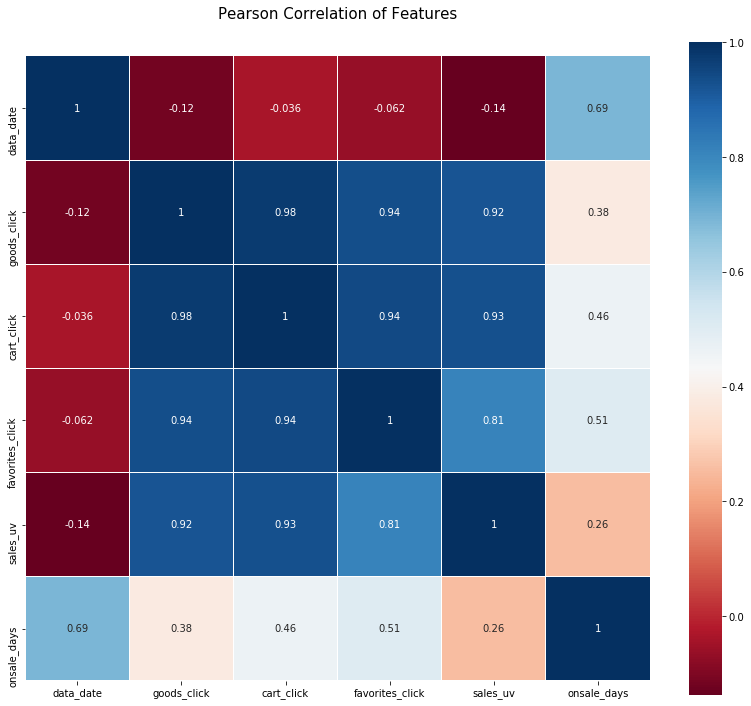

In [102]:
# 看下每天商品销售情况各特征的相关性
colormap = plt.cm.RdBu
plt.figure(figsize=(14,12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(daily_sum.astype(float).corr(),linewidths=0.1,vmax=1.0, 
            square=True, cmap=colormap, linecolor='white', annot=True)

加购和点击量差不多完全线性相关(.98), 而且和销量也基本线性相关(.93), 而收藏量由于延迟等原因没有那么相关(.81)

In [103]:
# TODO: 整合出新 feature: popularity / user_interest

['data_date' 'goods_click' 'cart_click' 'favorites_click' 'sales_uv'
 'onsale_days']


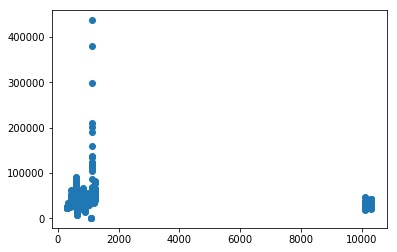

In [104]:
print(daily_sum.columns.values)
plt.scatter(daily_sum['data_date'] - 20170000, daily_sum['sales_uv'])

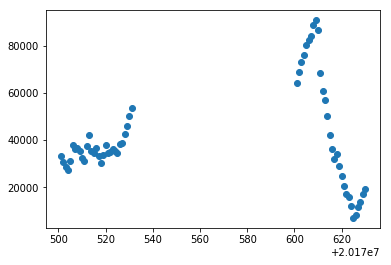

In [105]:
# 挑几个月看下日销售情况
first2mons_daily_sum = daily_sum[(20170500 < daily_sum['data_date']) & \
                                 (daily_sum['data_date'] < 20170700)]
plt.scatter(first2mons_daily_sum['data_date'], first2mons_daily_sum['sales_uv'])

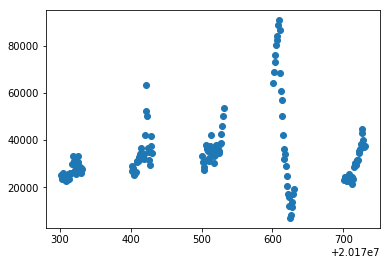

In [106]:
first2mons_daily_sum = daily_sum[(20170300 < daily_sum['data_date']) & (daily_sum['data_date'] < 20170800)]
plt.scatter(first2mons_daily_sum['data_date'], first2mons_daily_sum['sales_uv'])

### goodsinfo 商品信息
商品的一些属性: 类目, 季节属性, 品牌id

In [107]:
goodsinfo.describe()

,cat_level1_id,cat_level2_id,cat_level3_id,cat_level4_id,cat_level5_id,cat_level6_id,cat_level7_id,goods_season,brand_id
count,423452.000000,423452.000000,423452.000000,423452.000000,423452.000000,423452.0,423452.0,423452.000000,423452.000000
mean,584.135057,1936.813084,2561.146871,383.653496,28.033529,-1.0,-1.0,1.213679,483.439719
std,1206.801739,2289.516917,1832.745418,1170.068380,362.907817,0.0,0.0,1.385024,1270.265420
min,2.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-1.0,0.000000,-1.000000
25%,2.000000,99.000000,666.000000,-1.000000,-1.000000,-1.0,-1.0,0.000000,0.000000
50%,59.000000,432.000000,2260.000000,-1.000000,-1.000000,-1.0,-1.0,0.000000,0.000000
75%,364.000000,3650.000000,4226.000000,-1.000000,-1.000000,-1.0,-1.0,2.000000,0.000000
max,5884.000000,6500.000000,6498.000000,6518.000000,6346.000000,-1.0,-1.0,10.000000,10146.000000


### goodssale 商品销售数据
每日sku, 价格

### goods_sku_relation 商品 sku 映射表

### goods_promote_price 促销价
加两列 start_time, end_time: 用来转换 promote_start_time, promote_end_time 成 int 型, 方便计算

In [78]:
goods_promote_price['start_time'] = goods_promote_price['promote_start_time'].apply(
    lambda x: int("".join(x.split(" ")[0].split("-"))))
goods_promote_price['end_time'] = goods_promote_price['promote_end_time'].apply(
    lambda x: int("".join(x.split(" ")[0].split("-"))))
goods_promote_price.head()

,data_date,goods_id,shop_price,promote_price,promote_start_time,promote_end_time,is_promoted,start_time,end_time
0,20180129,GBLrYn,289.00,0.0,1970-01-01 08:00:00,1970-01-01 08:00:00,0,19700101,19700101
1,20180129,GfrkEb,17.99,0.0,1970-01-01 08:00:00,1970-01-01 08:00:00,0,19700101,19700101
2,20180129,GD8pMl,412.00,0.0,1970-01-01 08:00:00,1970-01-01 08:00:00,0,19700101,19700101
3,20180129,Gfid4P,87.00,0.0,1970-01-01 08:00:00,1970-01-01 08:00:00,0,19700101,19700101
4,20180129,Gzjk0i,43.99,0.0,1970-01-01 08:00:00,1970-01-01 08:00:00,0,19700101,19700101


In [79]:
goods_promote_price.describe()

,data_date,shop_price,promote_price,is_promoted,start_time,end_time
count,2.401643e+07,2.401643e+07,2.401643e+07,2.401643e+07,2.401643e+07,2.401643e+07
mean,2.018022e+07,3.837252e+01,7.274269e+00,3.636113e-01,1.987316e+07,1.987458e+07
std,6.789219e+01,5.922209e+01,1.518260e+01,4.810386e-01,2.287823e+05,2.306283e+05
min,2.018012e+07,0.000000e+00,0.000000e+00,0.000000e+00,1.970010e+07,1.970010e+07
25%,2.018013e+07,1.899000e+01,0.000000e+00,0.000000e+00,1.970010e+07,1.970010e+07
50%,2.018022e+07,2.999000e+01,0.000000e+00,0.000000e+00,1.970010e+07,1.970010e+07
75%,2.018030e+07,4.299000e+01,1.199000e+01,1.000000e+00,2.017122e+07,2.018021e+07
max,2.018032e+07,1.787700e+04,1.500000e+03,1.000000e+00,2.018032e+07,2.020123e+07


In [80]:
goods_promote_price.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24016430 entries, 0 to 24016429
Data columns (total 9 columns):
data_date             int64
goods_id              object
shop_price            float64
promote_price         float64
promote_start_time    object
promote_end_time      object
is_promoted           int64
start_time            int64
end_time              int64
dtypes: float64(2), int64(4), object(3)
memory usage: 1.6+ GB


In [60]:
# 看有没有错误促销
goods_promote_price[goods_promote_price['shop_price'] < goods_promote_price['promote_price']]

,data_date,goods_id,shop_price,promote_price,promote_start_time,promote_end_time


不存在 标价<促销价, 还行

In [85]:
# 加 is_promoted 列 表示是否为促销产品
goods_promote_price['is_promoted'] = 0
is_promoted = (goods_promote_price['promote_price'] > .0) & \
    (goods_promote_price['start_time'] < goods_promote_price['data_date']) & \
    (goods_promote_price['end_time'] > goods_promote_price['data_date'])

goods_promote_price.loc[is_promoted, 'is_promoted'] = 1

In [88]:
goods_promote_price.head()

,data_date,goods_id,shop_price,promote_price,promote_start_time,promote_end_time,is_promoted,start_time,end_time
0,20180129,GBLrYn,289.00,0.0,1970-01-01 08:00:00,1970-01-01 08:00:00,0,19700101,19700101
1,20180129,GfrkEb,17.99,0.0,1970-01-01 08:00:00,1970-01-01 08:00:00,0,19700101,19700101
2,20180129,GD8pMl,412.00,0.0,1970-01-01 08:00:00,1970-01-01 08:00:00,0,19700101,19700101
3,20180129,Gfid4P,87.00,0.0,1970-01-01 08:00:00,1970-01-01 08:00:00,0,19700101,19700101
4,20180129,Gzjk0i,43.99,0.0,1970-01-01 08:00:00,1970-01-01 08:00:00,0,19700101,19700101


现在用 goods_promote_price 这个表给 goods_id + data_date 查询就可以用 is_promoted 判断某个商品在某天是不是促销

### marketing: 平台活动时间表
活动类型, 节奏类型